In [33]:
# data from: https://www.kaggle.com/datasets/bahadoreizadkhah/face-mask-types-dataset/code
# reference: https://towardsdatascience.com/from-alexnet-to-nasnet-a-brief-history-and-introduction-of-convolutional-neural-networks-cf63bf3320e1 
# reference: https://github.com/Alexiush/weak-causality-and-causal-disposition-in-images/blob/main/ca_cnn_sample_resnet.ipynb

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import models
from sklearn.metrics import confusion_matrix
import pathlib

In [34]:
data_train = pathlib.Path('./Dataset/train')
data_test = pathlib.Path('./Dataset/test')

INPUT_SIZE = [300, 300]
BATCH = 6

In [86]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, 
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.0,
    rescale=1./255
    )

training_data = training_datagen.flow_from_directory('./Dataset/train', 
                                                     subset="training", 
                                                     shuffle=True, 
                                                     target_size=INPUT_SIZE, 
                                                     batch_size=BATCH, 
                                                     color_mode="rgb",
                                                     class_mode='categorical')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory('./Dataset/test', 
                                             target_size=INPUT_SIZE, 
                                             color_mode="rgb", 
                                             batch_size=BATCH,
                                             class_mode='categorical',
                                             shuffle=False)

# display dimensions
x_test, y_test = next(test_data)
x_train, y_train = next(training_data)

Found 1956 images belonging to 5 classes.
Found 330 images belonging to 5 classes.


KeyboardInterrupt: 

In [36]:
# pooling='avg' => same as adding GlobalAveragePooling2D 
resn_model = tf.keras.applications.ResNet101V2(input_shape=(300, 300,3), include_top=False, weights='imagenet')
resn_model.trainable = True

fine_tune_at = 100
for layer in resn_model.layers[:fine_tune_at]:
    layer.trainable =  False

resn_model.summary()

Model: "resnet101v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 306, 306,  │          0 │ input_layer_16[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 150, 150,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 152, 152,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 75, 75,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 75, 75,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 75, 75,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 75, 75,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 75, 75,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 75, 75,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 77, 77,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 75, 75,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 75, 75,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 75, 75,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 75, 75,    │          0 │ conv2_block1_0_c

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 39,569,408 (150.95 MB)

 Non-trainable params: 3,057,152 (11.66 MB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.270355 to fit



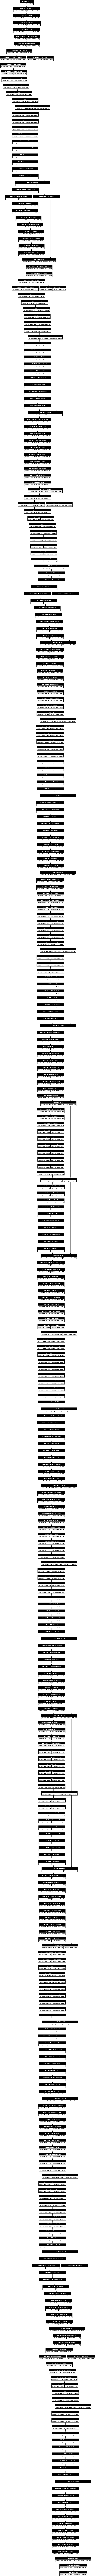

In [37]:
import tensorflow as tf

tf.keras.utils.plot_model(resn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

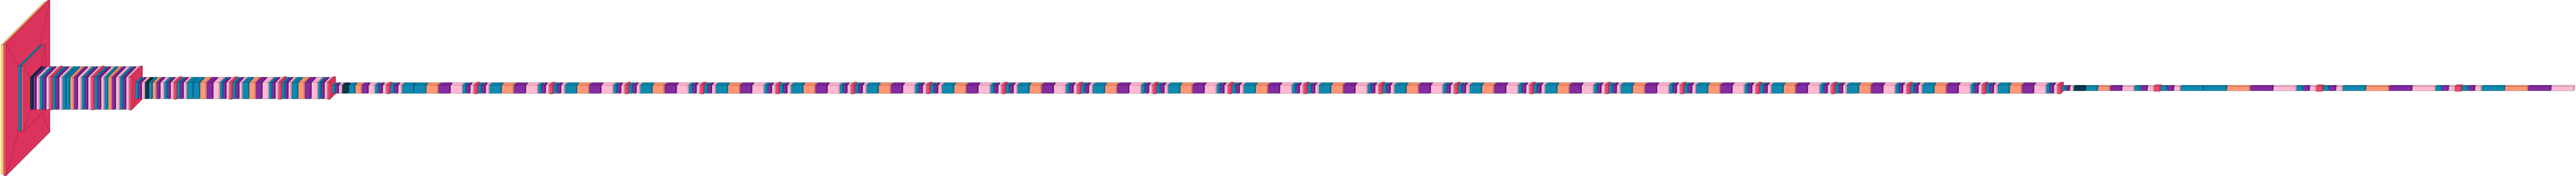

In [38]:
import visualkeras

visualkeras.layered_view(resn_model)

In [58]:
model = models.Sequential([# Lambda(lambda x: x, input_shape=(300, 300, 3)), 
    tf.keras.layers.InputLayer((300, 300, 3)),
    resn_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(5, activation='softmax')])

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ (None, 10, 10, 2048)   │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 100)            │       204,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,831,965 (163.39 MB)

 Trainable params: 39,774,813 (151.73 MB)

 Non-trainable params: 3,057,152 (11.66 MB)

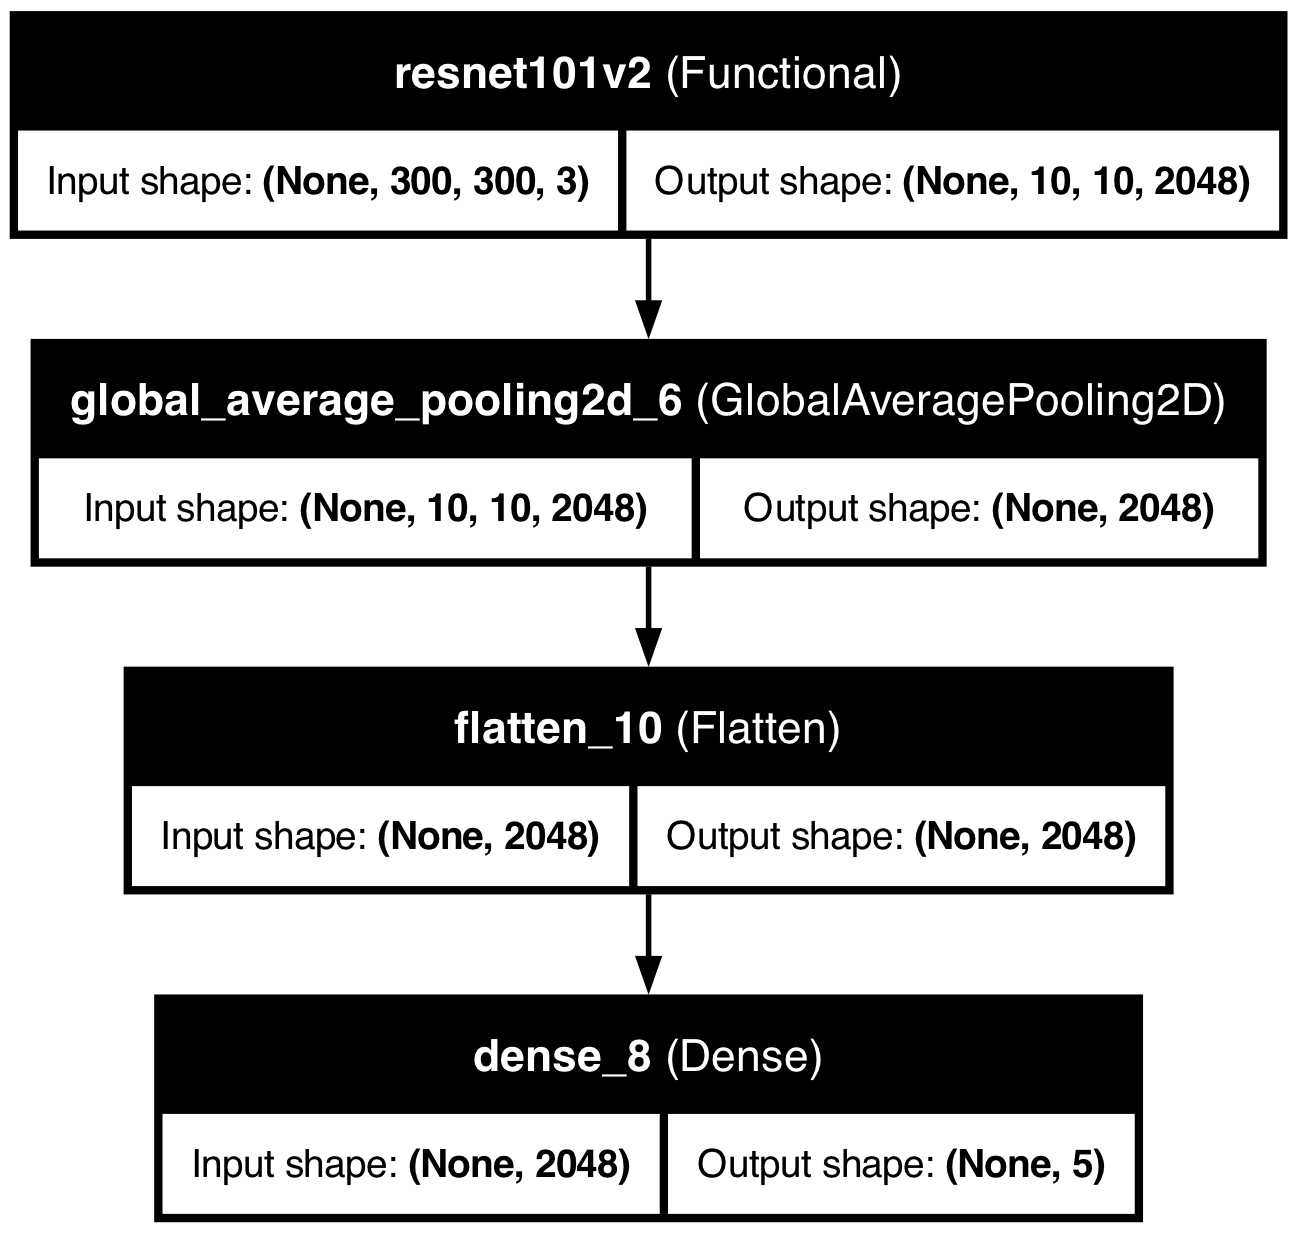

In [40]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

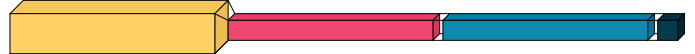

In [41]:
visualkeras.layered_view(model)

In [59]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam', 
    metrics=['accuracy']
)
#  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)

history = model.fit(
    training_data,
    validation_data=test_data,
    epochs=5,
    # batch_size=BATCH,
    # steps_per_epoch=len(training_data),
    # validation_steps=len(test_data)
)

Epoch 1/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 696s 2s/step - accuracy: 0.5924 - loss: 1.0398 - val_accuracy: 0.6545 - val_loss: 0.8808
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 597s 2s/step - accuracy: 0.6915 - loss: 0.7793 - val_accuracy: 0.4758 - val_loss: 5.5782
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 649s 2s/step - accuracy: 0.7494 - loss: 0.7084 - val_accuracy: 0.7364 - val_loss: 0.6640
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 695s 2s/step - accuracy: 0.7871 - loss: 0.5906 - val_accuracy: 0.8061 - val_loss: 0.5393
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 714s 2s/step - accuracy: 0.8010 - loss: 0.5496 - val_accuracy: 0.8455 - val_loss: 0.4774


In [60]:
# create confusion matrix
y_pred=model.predict(test_data, batch_size=BATCH)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

cm=confusion_matrix(test_data.classes, y_pred)
print(cm)

#Impresion de la exactitud
accu = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accu =accu.diagonal()
print(accu)

loss, accuracy = model.evaluate(test_data, verbose=0)
print(loss, accuracy)

55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 509ms/step
(330, 5)
[0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 2 0 0 1 0 1 0 0 0 1 0 0 1 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 2 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 4 0 0 1 2 1 1 1 1 0 1 1 1 1
 1 4 1 4 2 1 1 2 1 1 1 1 1 1 1 1 1 4 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 1 2 0 2 2 2 2 2 1 2 2 1 4 1 4 3 1 3 3 3 3 3
 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 1 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 0 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4
 4 1 4 4 4 4 4 4 4 1 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 0 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4]
[[63 10  4  1  0]
 [ 6 38  3  0  3]
 [ 1  8 38  0  2]
 [ 3  2  1 71  1]
 [ 2  4  0  0 69]]
[0.80769231 0.76       0.7755102  0.91025641 0.92      ]
0.4773510992527008 0.8454545736312866


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_data.classes, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['cloth', 'n95', 'n95v', 'nfm', 'srg'], yticklabels=['cloth', 'n95', 'n95v', 'nfm', 'srg'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Data Train')
plt.show()

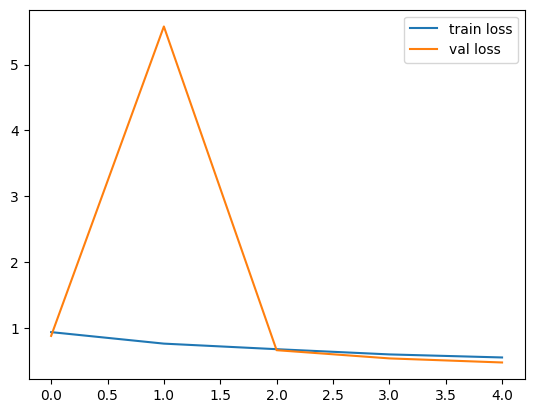

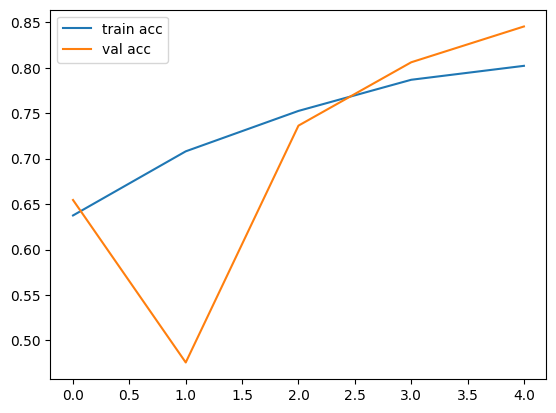

In [61]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')

In [62]:
import numpy as np

test_image = tf.keras.preprocessing.image.load_img(
    './Dataset/test/cloth/1.jpg',
    target_size=INPUT_SIZE)
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = test_image / 255
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
i = np.argmax(result[0])
classes = training_data.class_indices.keys()
print(classes)
list(classes)[i]

# if result[0][0] < 0.5:
#     print('Image classified as WithMAsk')
# else:
#     print('Image classified as Without Mask')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
dict_keys(['cloth', 'n95', 'n95v', 'nfm', 'srg'])


'cloth'

['cloth', 'n95', 'n95v', 'nfm', 'srg']
n95


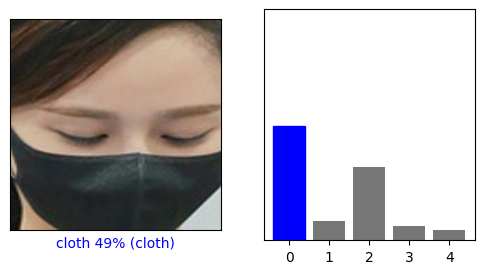

In [109]:
def plot_image(j, predictions_array, true_label, img):
    true_label, img = true_label[j], img[j]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == np.argmax(true_label):
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(classes[predicted_label],
                                         100*np.max(predictions_array),
                                         classes[np.argmax(true_label)]),
               color=color)

def plot_value_array(k, predictions_array, true_label):
    true_label = true_label[k]
    plt.grid(False)
    plt.xticks(range(5))
    plt.yticks([])
    thisplot = plt.bar(range(5), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[np.argmax(true_label)].set_color('blue')

i = 1
print(classes)
print(classes[i])

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
# print(x_test)
# print(np.argmax(x_test))
plot_image(i, result, y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, result[0], y_test)
plt.show()

# i = 0
# plt.figure(figsize=(6,3))
# plt.subplot(1,2,1)
# plot_image(i, predictions[i], test_labels, test_images)
# plt.subplot(1,2,2)
# plot_value_array(i, predictions[i],  test_labels)
# plt.show()